# Seção 14.05b - Regressão Polinomial com Ridge, Lasso e Rede elástica (base preço casas)
Para esta seção, usarei a base de dados plano_saude.csv do curso do Prof. Jones Granatyr.

## Penalizações
Segundo o prof. Eduardo Vargas Ferreira (LEG-UFPR), em situações onde há um número maior de variáveis independentes/fatores que de registros ("*small n, large p*"), os métodos de análise de dados pode falhar.

Uma das saídas, para modelos lineares são as penalizações. Elas servem para reduzir o crescimento dos coeficientes da regressão e/ou reduzir/selecionar a quantidade de fatores/variáveis independentes. Neste notebook veremos a Ridge, Lasso e Rede elástica.

A penalização nada mais é do que um novo fator na função de custo.

**Função de custo original (MSE, nesse caso):**
$$
min(\sum_{i=1}^{n}(y_{real_i}-(\beta_{0}+\sum_{j=1}^{p}\beta_{j}x_{ij}))^2)
$$
$$
min(\sum_{i=1}^{n}(y_{real_i}-\hat{y}_{predito_i})^2)
$$

**Penalização (genérica, nesse caso):**
$$
\lambda*\sum_{j=1}^{n}|\beta_{j}|^q
$$
Sendo que a variação do termo *q* implicará no tipo de regularização. Por exemplo, se *q=1*, trata-se da regularização de *Lasso*; e, se *q=2*, trata-se da regularização de *Ridge*.

## Regularização de Ridge
$$
min(\sum_{i=1}^{n}(y_{real_i}-\hat{y}_{predito_i})^2 + \lambda*\sum_{j=1}^{n}|\beta_{j}|^2)
$$

A penalização de Ridge **NÃO** seleciona fatores, apenas impede seu crescimento.

## Regularização de Lasso
$$
min(\sum_{i=1}^{n}(y_{real_i}-\hat{y}_{predito_i})^2 + \lambda*\sum_{j=1}^{n}|\beta_{j}|)
$$

A penalização de Lasso **SELECIONA** fatores.

## Regularização de Rede Elástica (Elastic Net)
Essa regularização acrescenta um termo que é um compromisso entre a Lasso e a Ridge.

$$
min(\sum_{i=1}^{n}(y_{real_i}-\hat{y}_{predito_i})^2 + \lambda*\sum_{j=1}^{n}(\alpha|\beta_{j}|+(1-\alpha)\beta_{j}^2))
$$
Sendo que alpha é um termo que "regula" a proporção entre Lasso e Ridge. No sklearn, o hiperparâmetro responsável por esse ajuste é o *l1_ratio*.

In [21]:
# Instruções basiconas de sempre.

# Lidar com dataframes.
import numpy as np
import pandas as pd

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import (show,
                      output_notebook)

# Lidar com preparação de dados.
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold)

# Lidar com validação de modelos.
from sklearn.metrics import (confusion_matrix
                             , accuracy_score
                             , classification_report
                             , mean_absolute_error
                             , mean_squared_error
                             , r2_score)

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [2]:
nomeDaBase = "../../bases/house-prices.csv"
df = pd.read_csv(nomeDaBase, sep=",", encoding="utf-8", index_col="id")

In [3]:
df.head(5).T

id,7129300520,6414100192,5631500400,2487200875,1954400510
date,20141013T000000,20141209T000000,20150225T000000,20141209T000000,20150218T000000
price,221900,538000,180000,604000,510000
bedrooms,3,3,2,4,3
bathrooms,1,2.25,1,3,2
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1,2,1,1,1
waterfront,0,0,0,0,0
view,0,0,0,0,0
condition,3,3,3,5,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(14), object(1)
memory usage: 3.4+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21613.0,540088.141767,367127.196483,75000.0000,321950.000,450000.0000,645000.000,7.700000e+06
bedrooms,21613.0,3.370842,0.930062,0.0000,3.000,3.0000,4.000,3.300000e+01
bathrooms,21613.0,2.114757,0.770163,0.0000,1.750,2.2500,2.500,8.000000e+00
sqft_living,21613.0,2079.899736,918.440897,290.0000,1427.000,1910.0000,2550.000,1.354000e+04
sqft_lot,21613.0,15106.967566,41420.511515,520.0000,5040.000,7618.0000,10688.000,1.651359e+06
floors,21613.0,1.494309,0.539989,1.0000,1.000,1.5000,2.000,3.500000e+00
waterfront,21613.0,0.007542,0.086517,0.0000,0.000,0.0000,0.000,1.000000e+00
view,21613.0,0.234303,0.766318,0.0000,0.000,0.0000,0.000,4.000000e+00
condition,21613.0,3.409430,0.650743,1.0000,3.000,3.0000,4.000,5.000000e+00
grade,21613.0,7.656873,1.175459,1.0000,7.000,7.0000,8.000,1.300000e+01


### Breve análise da  base:
- não há nulos;
- existem 21 variáveis, 20 variáveis independentes e a variável dependente, price; e
- só há uma variável "não numérica", a date.

### Próximos passos:
- apenas para simplificação, não usarei o atributo *date* nesta análise; e
- farei um diagrama de correlação para encontrar o atributo com maior correlação com price.

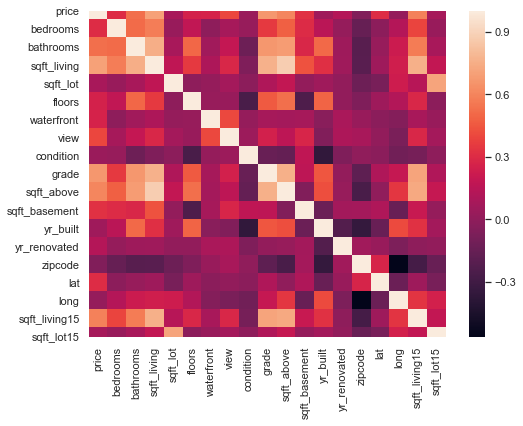

In [6]:
sns.set()
dimensoes = (8,6)
fig, ax = plt.subplots(figsize=dimensoes)
sns.heatmap(df.corr())

In [7]:
df.corr()["price"].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
zipcode         -0.053203
Name: price, dtype: float64

In [8]:
df.corr()[abs(df.corr()["price"]) > .5]["price"].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
Name: price, dtype: float64

In [9]:
# Separando os fatores/previsores da resposta/target:

x = df.drop(["price", "date"], axis=1).values
y = df["price"].values.reshape(-1,1)

# IMPORTANTE! Tive que fazer um reshape nos valores de x e y.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [11]:
atributos = df.drop(["price", "date"], axis=1).columns

In [23]:
from sklearn.linear_model import (LinearRegression
                                  , Ridge
                                  , Lasso
                                  , ElasticNet)

regressor = LinearRegression()
regressor_ridge = Ridge(alpha=50000)
regressor_lasso = Lasso(alpha=50000)
regressor_elastic = ElasticNet(alpha=50000, l1_ratio=.8)

regressor.fit(x_train, y_train)
regressor_ridge.fit(x_train, y_train)
regressor_lasso.fit(x_train, y_train)
regressor_elastic.fit(x_train, y_train)

y_pred = regressor.predict(x_test)
y_pred_ridge = regressor_ridge.predict(x_test)
y_pred_lasso = regressor_lasso.predict(x_test)
y_pred_elastic = regressor_elastic.predict(x_test)

In [24]:
print("Intercepto = {:.3f}".format(regressor.intercept_[0]))

i = 0
print(f"""\n\nRegressão Linear sem regularização\n""")

for i, coeficiente in enumerate(regressor.coef_[0]):
    print(f"""Coeficiente [{i+1}] / {atributos[i]}= {coeficiente:.3f}""")
    
print("-"*40)

i = 0

print(f"""\n\nRegressão Linear com regularização Ridge\n""")

for i, coeficiente in enumerate(regressor_ridge.coef_[0]):
    print(f"""Coeficiente [{i+1}] / {atributos[i]}= {coeficiente:.3f}""")

print("-"*40)
    
i = 0

print(f"""\n\nRegressão Linear com regularização Lasso\n""")

for i, coeficiente in enumerate(regressor_lasso.coef_):
    print(f"""Coeficiente [{i+1}] / {atributos[i]}= {coeficiente:.3f}""")
    
print("-"*40)

i = 0

print(f"""\n\nRegressão Linear com regularização Rede Elástica\n""")

for i, coeficiente in enumerate(regressor_elastic.coef_):
    print(f"""Coeficiente [{i+1}] / {atributos[i]}= {coeficiente:.3f}""")

Intercepto = 3684410.887


Regressão Linear sem regularização

Coeficiente [1] / bedrooms= -32813.456
Coeficiente [2] / bathrooms= 34253.487
Coeficiente [3] / sqft_living= 110.994
Coeficiente [4] / sqft_lot= 0.187
Coeficiente [5] / floors= 11580.509
Coeficiente [6] / waterfront= 612181.593
Coeficiente [7] / view= 50578.675
Coeficiente [8] / condition= 27213.516
Coeficiente [9] / grade= 94238.604
Coeficiente [10] / sqft_above= 66.998
Coeficiente [11] / sqft_basement= 43.996
Coeficiente [12] / yr_built= -2562.341
Coeficiente [13] / yr_renovated= 21.743
Coeficiente [14] / zipcode= -548.654
Coeficiente [15] / lat= 604734.298
Coeficiente [16] / long= -210508.922
Coeficiente [17] / sqft_living15= 28.420
Coeficiente [18] / sqft_lot15= -0.435
----------------------------------------


Regressão Linear com regularização Ridge

Coeficiente [1] / bedrooms= -8045.859
Coeficiente [2] / bathrooms= 3245.230
Coeficiente [3] / sqft_living= 159.910
Coeficiente [4] / sqft_lot= 0.080
Coeficiente [5] / flo

### Importante!
Notar que o uso das regularizações Lasso e Elastic Net reduziram / selecionaram alguns dos fatores/variáveis independentes. 

### Verificando o como o modelo se saiu

In [25]:
lista_y_pred = (y_pred, y_pred_ridge, y_pred_lasso, y_pred_elastic)
lista_y_pred_nomes = {1:"Sem regularização", 2:"Ridge",3:"Lasso",4:"Elastic Net"}

for i, pred in enumerate(lista_y_pred):
    print(lista_y_pred_nomes[i+1])
    print("MSE: {:.3f}".format(mean_squared_error(y_test, pred)))
    print("RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_test, pred))))
    print("MAE: {:.3f}".format(mean_absolute_error(y_test, pred)))
    # print("MAPE:, ", mean_absolute_percentage_error(y_test, y_pred))
    print("R2: {:.3f}".format(r2_score(y_test, pred)))

    ################################################################################
    # Cálculo do R2 ajustado:
    def r2_ajustado(x, y, pred):
        """
        r2_ajustado retorna o R² Ajustado e recebe como argumento as séries com o
        valor alvo teste e o predito.
        """
        n = x.shape[0]
        k = x.shape[1]
        return (1-((n-1)/(n-(k+1)))*(1-r2_score(y, pred)))
    ################################################################################

    print("R2 Ajustado: {:.3}".format(r2_ajustado(x_test, y_test, pred)))
    print("-"*40)

Sem regularização
MSE: 41168199240.646
RMSE: 202899.481
MAE: 123556.906
R2: 0.690
R2 Ajustado: 0.689
----------------------------------------
Ridge
MSE: 58348290608.581
RMSE: 241553.908
MAE: 155956.878
R2: 0.561
R2 Ajustado: 0.559
----------------------------------------
Lasso
MSE: 59389160579.620
RMSE: 243698.914
MAE: 157299.019
R2: 0.553
R2 Ajustado: 0.551
----------------------------------------
Elastic Net
MSE: 65470142974.436
RMSE: 255871.341
MAE: 167766.486
R2: 0.507
R2 Ajustado: 0.506
----------------------------------------


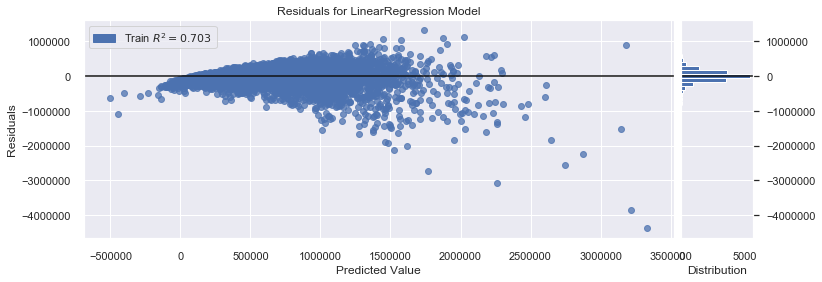

In [17]:
from yellowbrick.regressor import ResidualsPlot

sns.set()
dimensoes = (12,4)
fig, ax = plt.subplots(figsize=dimensoes)

visualizador = ResidualsPlot(regressor)
visualizador.fit(x_train, y_train)
visualizador.poof();

## Transformando os atributos em atributos polinomiais

In [18]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(x)

In [19]:
regressorPolinomial = LinearRegression()
regressorPolinomial.fit(x_poly, y)

y_poly_pred = regressorPolinomial.predict(x_poly)

### Verificando o como o modelo se saiu

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("MSE: {:.3f}".format(mean_squared_error(y, y_poly_pred)))
print("RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y, y_poly_pred))))
print("MAE: {:.3f}".format(mean_absolute_error(y, y_poly_pred)))
# print("MAPE:, ", mean_absolute_percentage_error(y_test, y_pred))
print("R2: {:.3f}".format(r2_score(y, y_poly_pred)))

################################################################################
# Cálculo do R2 ajustado:
def r2_ajustado(x, y, y_pred):
    """
    r2_ajustado retorna o R² Ajustado e recebe como argumento as séries com o
    valor alvo teste e o predito.
    """
    n = x.shape[0]
    k = x.shape[1]
    return (1-((n-1)/(n-(k+1)))*(1-r2_score(y, y_pred)))
################################################################################

print("R2 Ajustado: {:.3}".format(r2_ajustado(x_poly, y, y_poly_pred)))

MSE: 18230971221.450
RMSE: 135022.114
MAE: 91965.739
R2: 0.865
R2 Ajustado: 0.856
